**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [96]:
## Mounting Google drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Motivation**: To create a multiclass classification model using a custom convolutional neural network in tensorflow

**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion
 

### Importing Skin Cancer Data

### Importing all the important libraries

In [97]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [98]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

root_path = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')

data_dir_test = pathlib.Path(root_path + '/Test')

In [99]:
##Getting count of images in both train and test directories

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [100]:
batch_size = 32
img_height = 180
img_width = 180

##### `Use 80% of the images for training, and 20% for validation.`

In [101]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  label_mode = 'categorical',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [102]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  label_mode = 'categorical',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [103]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [104]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### To do: Create a code to visualize one instance of all the nine classes present in the dataset

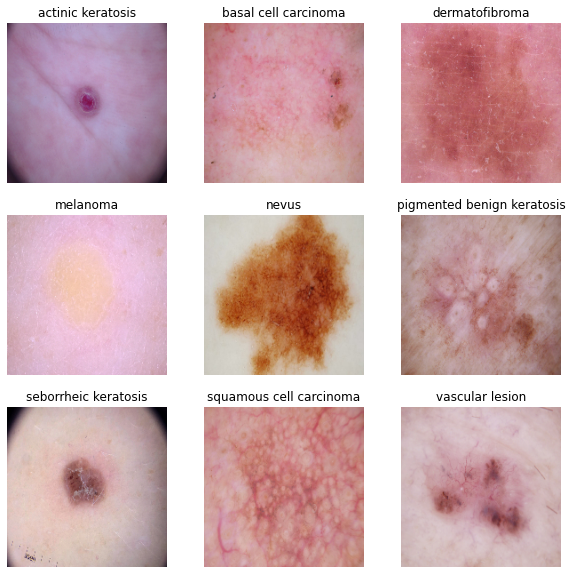

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [106]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [107]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [108]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [109]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [110]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_33 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 88, 88, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 86, 86, 64)       256       
 chNormalization)                                     

### Train the model

In [111]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 26s 211ms/step - loss: 20.7752 - accuracy: 0.2645 - val_loss: 6.3246 - val_accuracy: 0.0626
Epoch 2/20
56/56 [==============================] - 8s 150ms/step - loss: 8.2425 - accuracy: 0.3209 - val_loss: 16.7286 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 8s 150ms/step - loss: 2.9669 - accuracy: 0.3398 - val_loss: 14.6908 - val_accuracy: 0.2237
Epoch 4/20
56/56 [==============================] - 8s 150ms/step - loss: 2.2375 - accuracy: 0.3521 - val_loss: 13.5602 - val_accuracy: 0.2215
Epoch 5/20
56/56 [==============================] - 8s 150ms/step - loss: 1.8175 - accuracy: 0.4219 - val_loss: 25.4449 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 8s 150ms/step - loss: 1.6981 - accuracy: 0.4475 - val_loss: 18.0574 - val_accuracy: 0.2617
Epoch 7/20
56/56 [==============================] - 8s 149ms/step - loss: 1.6512 - accuracy: 0.4805 - val_loss: 7.9504 - val_accuracy: 0.3199

### Visualizing training results

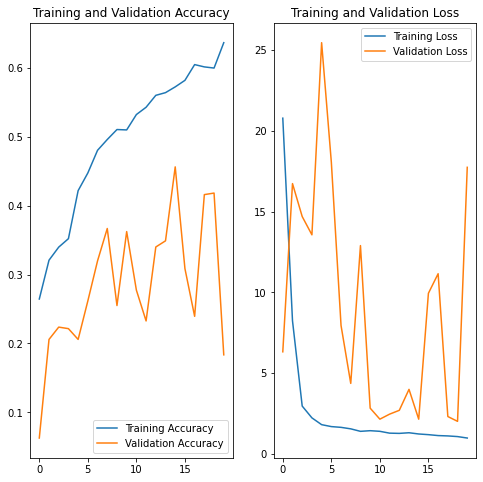

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
- The model has a training accuracy approx 63.67%
- The model has a validation accuracy approx 18.34%

#### Model Overfit or Underfit?


- The training accuracy is above 60% whereas validation accuracy is too low, which suggests that the model is overfit model.
- We need to address the overfitting so that the model performs good for validation set also.

### Model 2
### Using `ImageDataGenerator`

In [114]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 32
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 32
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


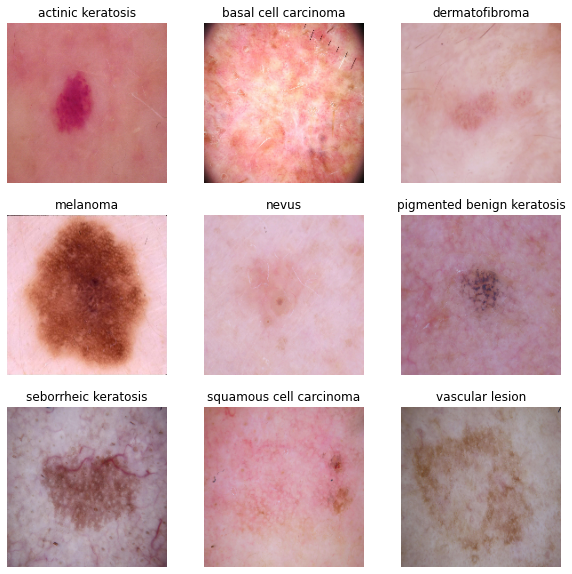

In [115]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")


### Create the model, compile and train the model


In [116]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()
# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_37 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_39 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

### Compiling the model

In [117]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [118]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [119]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 32
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
28/28 [==============================] - 44s 2s/step - loss: 59.4284 - accuracy: 0.4494 - val_loss: 1.6875 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 2/20
28/28 [==============================] - 40s 1s/step - loss: 1.0198 - accuracy: 0.4820 - val_loss: 1.7059 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
28/28 [==============================] - 39s 1s/step - loss: 0.9464 - accuracy: 0.5427 - val_loss: 1.6574 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
28/28 [==============================] - 40s 1s/step - loss: 0.8951 - accuracy: 0.5551 - val_loss: 1.5132 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/20
28/28 [==============================] - 40s 1s/step - loss: 0.8296 - accuracy: 0.6202 - val_loss: 1.4112 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/20
28/28 [==============================] - 40s 1s/step - loss: 0.7834 - accuracy: 0.6427 - val_loss: 1.5852 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 7/20
28/28 [==============================] - 40s 1s/step - loss: 0.7835 - 

### Visualizing the results

<built-in method keys of dict object at 0x7fa1b4741370> :


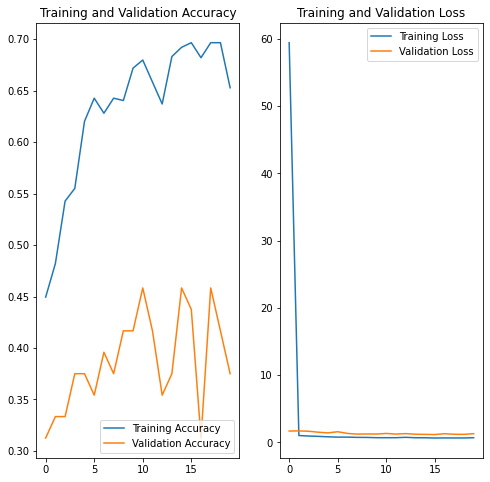

In [120]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- The model accuracy stays around previous model but validation accuracy improved significantly.
- We tried to address the overfitting of the base model, but it seems to have impacted the overall accuracy of the model as well.
- We need to try and find different approach to improve model accuracy further.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [122]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

class_df = class_distribution_count(data_dir_train)
class_df

,Class,No. of Image
0,actinic keratosis,114
1,dermatofibroma,95
2,pigmented benign keratosis,462
3,vascular lesion,139
4,melanoma,438
5,seborrheic keratosis,77
6,nevus,357
7,squamous cell carcinoma,181
8,basal cell carcinoma,376


<BarContainer object of 9 artists>

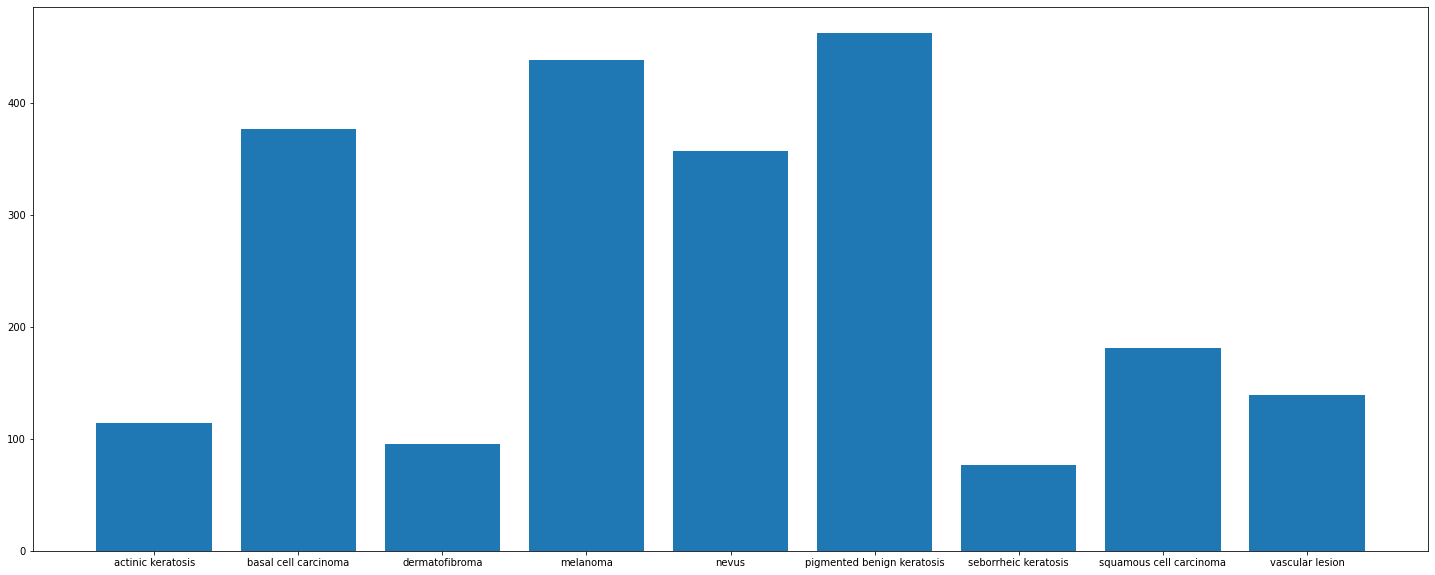

In [123]:
#Visualize the Number of image in each class.
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


#### - Which class has the least number of samples? - **Actinic Keratosos** and **Seborrheic keratosis**

- It appears from the above graph that the Class `Seborrheic Keratosis` has the least number of samples.

#### - Which classes dominate the data in terms proportionate number of samples?

- **Pigmented benign keratosis** dominates the data in terms of number of samples size 462.


In [124]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [125]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA2A0428790>: 100%|██████████| 500/500 [00:25<00:00, 19.42 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1B4E7B210>: 100%|██████████| 500/500 [00:25<00:00, 19.51 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA2A0464550>: 100%|██████████| 500/500 [00:28<00:00, 17.80 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA2A0695FD0>: 100%|██████████| 500/500 [01:48<00:00,  4.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FA2A71AA6D0>: 100%|██████████| 500/500 [01:45<00:00,  4.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA22AD7BF50>: 100%|██████████| 500/500 [00:23<00:00, 21.31 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA22AC67110>: 100%|██████████| 500/500 [00:53<00:00,  9.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA2A0560910>: 100%|██████████| 500/500 [00:24<00:00, 20.50 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA2A00EF450>: 100%|██████████| 500/500 [00:24<00:00, 20.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [126]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [127]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_565f4ba5-e599-431c-be32-66b4ae735158.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_8772dbcd-37bd-4757-b068-baf9b49e7fa1.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_7c48ca7d-d2fd-436e-9a54-c8e2813ba647.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_88887efd-1724-4718-8b01-faae5a5abd24.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026171.jpg_c9f3d159-ce95

In [128]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [129]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [130]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [131]:
new_df['Label'].value_counts()

actinic keratosis             500
dermatofibroma                500
pigmented benign keratosis    500
vascular lesion               500
melanoma                      500
seborrheic keratosis          500
nevus                         500
squamous cell carcinoma       500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

## Model 3

In [132]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [133]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode = 'categorical',
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [134]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode = 'categorical',
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [135]:

model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_42 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 90, 90, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 90, 90, 32)       

#### Compile your model (Choose optimizer and loss function appropriately)

In [136]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

####  Train your model

In [137]:
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 32
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
169/169 [==============================] - 63s 358ms/step - loss: 1.9885 - accuracy: 0.3540 - val_loss: 3.6957 - val_accuracy: 0.1173 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 46s 267ms/step - loss: 1.5709 - accuracy: 0.4445 - val_loss: 2.5868 - val_accuracy: 0.1581 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 48s 275ms/step - loss: 1.3287 - accuracy: 0.5210 - val_loss: 2.0081 - val_accuracy: 0.2955 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 46s 267ms/step - loss: 1.2052 - accuracy: 0.5627 - val_loss: 1.1528 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 46s 265ms/step - loss: 1.0518 - accuracy: 0.6150 - val_loss: 1.6004 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 46s 265ms/step - loss: 1.0208 - accuracy: 0.6272 - val_loss: 1.3634 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

####  Visualize the model results

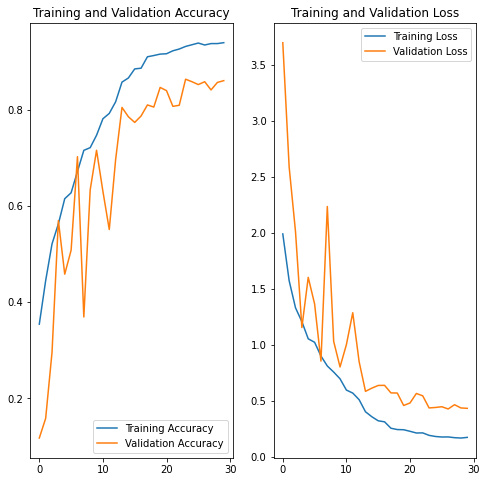

In [138]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:

- The training accuracy of the model is 93.94% after 30th epoch.
- The validation accuracy of the model is 86.04% after 30th epoch.

#### Did you get rid of underfitting/overfitting? Did class rebalance help?

- Yes, final model has very good accuracy on both training and validation set.

### Conclusion:
- Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

- Then we introduced dropout and ImageDataGenerator which reduced the over fit

- At last we tried Batch Normalization and Augumentation which really helped in carry forward